<a href="https://colab.research.google.com/github/andrewginns/model_interpretability/blob/master/Shapley_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro
This notebook shows how to utilise the [shap python library](https://pypi.org/project/shap/) to interpret tree based models. The aim is to provide a practical reference for use of shap on common tree based models.

Each of the implemented models is trained to predict house price on the California Housing dataset. Each is tuned to provide a good representation of an effective model.

The built in feature importance measures are then plotted for the trained models. These can then be compared to the plots generated by the shap library.

Main references:
1.   https://github.com/slundberg/shap
2.   https://towardsdatascience.com/interpretable-machine-learning-with-xgboost-9ec80d148d27
3.   https://towardsdatascience.com/explain-your-model-with-the-shap-values-bc36aac4de3d



# Dependencies

In [106]:
!pip install shap

In [0]:
import pandas as pd
import numpy as np
import sklearn
import shap

# Prepare Housing Dataset

## Load data from the Colaboratory samples

In [0]:
housing_train_pd = pd.read_csv('/content/sample_data/california_housing_train.csv')
housing_test_pd = pd.read_csv('/content/sample_data/california_housing_test.csv')

In [109]:
housing_train_pd.head(5)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-114.31,34.19,15.0,5612.0,1283.0,1015.0,472.0,1.4936,66900.0
1,-114.47,34.40,19.0,7650.0,1901.0,1129.0,463.0,1.8200,80100.0
2,-114.56,33.69,17.0,720.0,174.0,333.0,117.0,1.6509,85700.0
3,-114.57,33.64,14.0,1501.0,337.0,515.0,226.0,3.1917,73400.0
4,-114.57,33.57,20.0,1454.0,326.0,624.0,262.0,1.9250,65500.0


In [110]:
housing_test_pd.head(5)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-122.05,37.37,27.0,3885.0,661.0,1537.0,606.0,6.6085,344700.0
1,-118.30,34.26,43.0,1510.0,310.0,809.0,277.0,3.5990,176500.0
2,-117.81,33.78,27.0,3589.0,507.0,1484.0,495.0,5.7934,270500.0
3,-118.36,33.82,28.0,67.0,15.0,49.0,11.0,6.1359,330000.0
4,-119.67,36.33,19.0,1241.0,244.0,850.0,237.0,2.9375,81700.0


## Check if any of the variables contain nan

In [111]:
print(housing_train_pd.isnull().any())
print(housing_test_pd.isnull().any())

longitude             False
latitude              False
housing_median_age    False
total_rooms           False
total_bedrooms        False
population            False
households            False
median_income         False
median_house_value    False
dtype: bool
longitude             False
latitude              False
housing_median_age    False
total_rooms           False
total_bedrooms        False
population            False
households            False
median_income         False
median_house_value    False
dtype: bool


## Shuffle the dataset

In [0]:
train_pd = housing_train_pd.sample(frac=1).reset_index(drop=True)
test_pd = housing_test_pd.sample(frac=1).reset_index(drop=True)

In [113]:
train_pd.head(5)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-115.51,33.24,32.0,1995.0,523.0,1069.0,410.0,1.6552,43300.0
1,-122.28,37.81,52.0,773.0,143.0,377.0,115.0,2.4083,98200.0
2,-118.40,34.08,52.0,3815.0,439.0,1266.0,413.0,15.0001,500001.0
3,-123.84,39.46,47.0,1150.0,244.0,552.0,201.0,2.5192,110400.0
4,-120.61,35.13,16.0,3431.0,721.0,1777.0,701.0,2.7301,190400.0


In [114]:
test_pd.head(5)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-121.97,38.04,38.0,2505.0,554.0,1595.0,498.0,2.5833,83500.0
1,-119.32,36.30,15.0,2864.0,571.0,1480.0,475.0,2.9698,93400.0
2,-119.46,36.91,12.0,2980.0,495.0,1184.0,429.0,3.9141,123900.0
3,-120.67,35.30,32.0,4202.0,986.0,2309.0,956.0,2.2165,231700.0
4,-121.20,38.69,26.0,3077.0,607.0,1603.0,595.0,2.7174,137500.0


## Scale the variables and split out train and test

In [0]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
# Training
X_train = scaler.fit_transform(train_pd.iloc[:, :-1])
y_train = np.array(train_pd.iloc[:, -1:]).ravel()
# Test
X_test = scaler.transform(test_pd.iloc[:, :-1])
y_test = np.array(test_pd.iloc[:, -1:]).ravel()

In [116]:
X_train

array([[0.88047809, 0.07438895, 0.60784314, ..., 0.02987752, 0.06725867,
        0.07967476],
       [0.2061753 , 0.56004251, 1.        , ..., 0.01048236, 0.01874692,
        0.13161198],
       [0.59262948, 0.16365569, 1.        , ..., 0.03539897, 0.06775201,
        1.        ],
       ...,
       [0.34960159, 0.52497343, 0.17647059, ..., 0.05485019, 0.09784575,
        0.15435649],
       [0.58665339, 0.15515409, 1.        , ..., 0.01045433, 0.0317382 ,
        0.23276231],
       [0.58665339, 0.15727949, 0.8627451 , ..., 0.04728272, 0.14306857,
        0.17570102]])

In [117]:
y_train

array([ 43300.,  98200., 500001., ..., 104600., 372000., 456200.])

In [118]:
X_test

array([[0.23705179, 0.58448459, 0.7254902 , ..., 0.04462008, 0.08172998,
        0.14368078],
       [0.50099602, 0.39957492, 0.2745098 , ..., 0.0413969 , 0.07794771,
        0.17033558],
       [0.48705179, 0.46439957, 0.21568627, ..., 0.0331007 , 0.07038316,
        0.23545882],
       ...,
       [0.25298805, 0.64187035, 0.31372549, ..., 0.02256229, 0.04686729,
        0.37675342],
       [0.61553785, 0.13283741, 0.56862745, ..., 0.07407719, 0.0906101 ,
        0.09875036],
       [0.38645418, 0.22422954, 0.60784314, ..., 0.03001766, 0.06183194,
        0.12643964]])

In [119]:
y_test

array([ 83500.,  93400., 123900., ..., 286000., 115900., 130200.])

# Train and interpret models
Currently implemented regressors:
1.   XGBoost
2.   Light Gradient Boost
3.   Random Forest



### Shared Code

In [0]:
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV

In [0]:
def evaluate_model(model_choice, X_train, y_train, X_test, y_test):
  """
  Function to evaluate an sklearn model and print various statistics

  Parameters:
  model_choice (sklearn.model): Trained model that you are evaluating
  X_train (numpy.ndarray): Training data
  y_train (numpy.ndarray): Test labels
  X_train (numpy.ndarray): Testing data
  y_test (numpy.ndarray): Test labels

  Returns: None
  """
  y_pred = model_choice.predict(X_test)

  print("Model Score for Training data: {}".format(model_choice.score(X_train,y_train)))
  print("Model Score for Testing data: {}".format(r2_score(y_test,y_pred)))
  print("Root Mean Squared Error is {}".format(np.sqrt(mean_squared_error(y_test,y_pred))))

In [0]:
def calc_shap_values(model, bg_size, X_source):
  """
  Calculates the shapley values for a given model's parameters

  Allows an approximation of shapley values for a given model based on a number of samples from a data source

  Parameters:
  model (sklearn.model): Model compatible with the sklearn API
  bg_size (int): Number of samples to build the background data
  X_source (numpy.ndarray): Source ndarray to sample

  Returns: matplotlib.axes._subplots.AxesSubplot
  """
  # Passing bg_size = 0 means the data exhaustively sampled
  if bg_size == 0:
    X_shap = X_source
  else:
    # Reduce the background data
    X_shap = shap.sample(X_source, bg_size)
  model_explainer = shap.TreeExplainer(model, X_shap)
  # Produce the shapley values
  model_shap_values = model_explainer.shap_values(X_shap)
  return model_shap_values, X_shap

In [0]:
def ABS_SHAP(df_shap, df):
  """
  Shows a simplified summary plot with colours indicating correlation to target variable

  It highlights the correlations in colors. The red color means a feature is positively correlated with the target variable
  Source: https://towardsdatascience.com/explain-your-model-with-the-shap-values-bc36aac4de3d

  Parameters:
  df_shap (numpy.ndarray): Array of shapley values
  df (pandas.core.frame.DataFrame): Pandas dataframe of source data

  Returns: matplotlib.axes._subplots.AxesSubplot
  """
  #import matplotlib as plt
  # Make a copy of the input data
  shap_v = pd.DataFrame(df_shap)
  feature_list = df.columns
  shap_v.columns = feature_list
  df_v = df.copy().reset_index().drop('index',axis=1)
  
  # Determine the correlation in order to plot with different colors
  corr_list = list()
  for i in feature_list:
      b = np.corrcoef(shap_v[i],df_v[i])[1][0]
      corr_list.append(b)
  corr_df = pd.concat([pd.Series(feature_list),pd.Series(corr_list)],axis=1).fillna(0)
  # Make a data frame. Column 1 is the feature, and Column 2 is the correlation coefficient
  corr_df.columns  = ['Variable','Corr']
  corr_df['Sign'] = np.where(corr_df['Corr']>0,'red','blue')
  
  # Plot it
  shap_abs = np.abs(shap_v)
  k=pd.DataFrame(shap_abs.mean()).reset_index()
  k.columns = ['Variable','SHAP_abs']
  k2 = k.merge(corr_df,left_on = 'Variable',right_on='Variable',how='inner')
  k2 = k2.sort_values(by='SHAP_abs',ascending = True)
  colorlist = k2['Sign']
  ax = k2.plot.barh(x='Variable',y='SHAP_abs',color = colorlist, figsize=(5,6),legend=False)
  ax.set_xlabel("SHAP Value (Red = Positive Impact)")

## XGBoost Regressor

### Random search optimiser

In [0]:
# random_grid = {
#         'num_boost_round': [10, 15, 20, 25, 30, 35, 40, 45, 50],
#         'eta': [0.05, 0.1, 0.2, 0.3, 0.4, 0.5],
#         'max_depth': [3, 4, 5, 6, 7, 8, 9],
#         'subsample': np.arange(0.5, 1.0, 0.1),
#         'colsample_bytree': np.arange(0.7, 1.0, 0.1),
#         'n_estimators': [10, 20, 30, 40, 50],
#         'alpha': [10, 20, 30, 40, 50]
#     }

In [0]:
# from xgboost import XGBRegressor
# # Use the random grid to search for best hyperparameters
# # First create the base model to tune
# xg = XGBRegressor(tree_method='gpu_hist', gpu_id=0, objective ='reg:squarederror', learning_rate = 0.1)
# # Random search of parameters, using 3 fold cross validation, 
# # search across 100 different combinations, and use all available cores
# random_xg = RandomizedSearchCV(estimator = xg, param_distributions = random_grid, n_iter = 1000, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# # Fit the random search model
# random_xg.fit(X_train, y_train)

In [0]:
# random_xg.best_estimator_

In [0]:
# evaluate_model(random_xg, X_train, y_train, X_test, y_test)

### Train an optimised XGBoost model

In [0]:
# BUG IN LIBRARY PREVENTS GPU TRAINED XGBOOST FROM FUNCTIONING
# Solution still needs to be merged into main code as of 9th May 2020

# from xgboost import XGBRegressor
# model_xg = XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
#              colsample_bynode=1, colsample_bytree=0.8999999999999999, eta=0.2,
#              gamma=0, gpu_id=0, importance_type='gain', learning_rate=0.1,
#              max_delta_step=0, max_depth=9, min_child_weight=1, missing=None,
#              n_estimators=50, n_jobs=1, nthread=None, num_boost_round=50,
#              objective='reg:squarederror', random_state=0, reg_alpha=0,
#              reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
#              subsample=0.8999999999999999, tree_method='gpu_hist', verbosity=1)
# %time model_xg.fit(X_train, y_train)

In [129]:
from xgboost import XGBRegressor
# model_xg = XGBRegressor(alpha=20, base_score=0.5, booster='gbtree', colsample_bylevel=1,
#              colsample_bynode=1, colsample_bytree=0.9, eta=0.3, gamma=0,
#              importance_type='gain', learning_rate=0.1,
#              max_delta_step=0, max_depth=5, min_child_weight=1, missing=None,
#              n_estimators=30, n_jobs=1, nthread=None, num_boost_round=50,
#              objective='reg:squarederror', random_state=0, reg_alpha=0,
#              reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
#              subsample=1.0, verbosity=1)

model_xg = XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8999999999999999, eta=0.2,
             gamma=0, importance_type='gain', learning_rate=0.1,
             max_delta_step=0, max_depth=9, min_child_weight=1, missing=None,
             n_estimators=50, n_jobs=1, nthread=None, num_boost_round=50,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
             subsample=0.8999999999999999, verbosity=1)

%time model_xg.fit(X_train, y_train)

CPU times: user 1.47 s, sys: 4.98 ms, total: 1.47 s
Wall time: 1.49 s


XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8999999999999999, eta=0.2,
             gamma=0, importance_type='gain', learning_rate=0.1,
             max_delta_step=0, max_depth=9, min_child_weight=1, missing=None,
             n_estimators=50, n_jobs=1, nthread=None, num_boost_round=50,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
             subsample=0.8999999999999999, verbosity=1)

In [130]:
evaluate_model(model_xg, X_train, y_train, X_test, y_test)

Model Score for Training data: 0.9378108739660554
Model Score for Testing data: 0.8267552688809323
Root Mean Squared Error is 47075.59520294496


### Standard feature importance plots
Here we use the standard feature importance plots common to sklearn and xgboost libraries.

The key takeaway is that these built in plots can show conflicting, disparate or ambiguous results.

In [0]:
import xgboost

[Text(0, 0, 'longitude'),
 Text(0, 0, 'latitude'),
 Text(0, 0, 'housing_median_age'),
 Text(0, 0, 'total_rooms'),
 Text(0, 0, 'total_bedrooms'),
 Text(0, 0, 'population'),
 Text(0, 0, 'households'),
 Text(0, 0, 'median_income')]

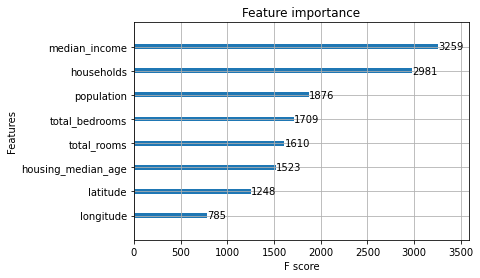

In [132]:
xgboost.plot_importance(model_xg).set_yticklabels(test_pd.columns[:-1])

[Text(0, 0, 'longitude'),
 Text(0, 0, 'latitude'),
 Text(0, 0, 'housing_median_age'),
 Text(0, 0, 'total_rooms'),
 Text(0, 0, 'total_bedrooms'),
 Text(0, 0, 'population'),
 Text(0, 0, 'households'),
 Text(0, 0, 'median_income')]

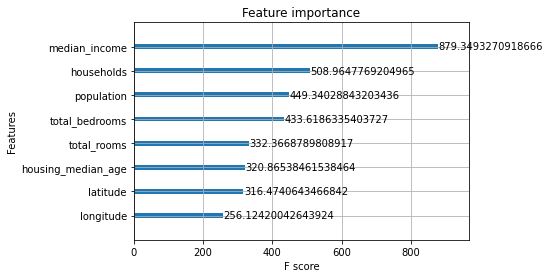

In [133]:
xgboost.plot_importance(model_xg, importance_type="cover").set_yticklabels(test_pd.columns[:-1])

[Text(0, 0, 'longitude'),
 Text(0, 0, 'latitude'),
 Text(0, 0, 'housing_median_age'),
 Text(0, 0, 'total_rooms'),
 Text(0, 0, 'total_bedrooms'),
 Text(0, 0, 'population'),
 Text(0, 0, 'households'),
 Text(0, 0, 'median_income')]

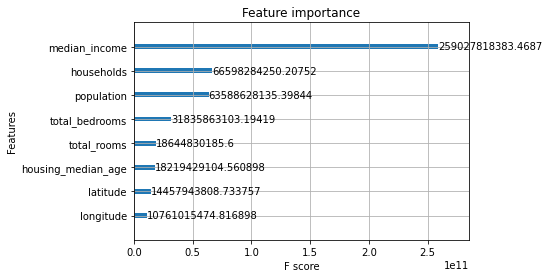

In [134]:
xgboost.plot_importance(model_xg, importance_type="gain").set_yticklabels(test_pd.columns[:-1])

### Use Shap library to explain feature contribution
We can use the Shap library to better explain feature contribution in terms of both magnitude, specific value impact and positive/negative contribution.

In [135]:
# Calculate shapley values for the model
%time xg_shap_values, X_shap = calc_shap_values(model_xg, bg_size=1000, X_source=X_test)

 98%|===================| 985/1000 [01:06<00:01]       

CPU times: user 1min 6s, sys: 151 ms, total: 1min 6s
Wall time: 1min 6s


The first plot is a variable importance plot lists the most significant variables in descending order.

The top variables contribute more to the model than the bottom ones and thus have high predictive power.

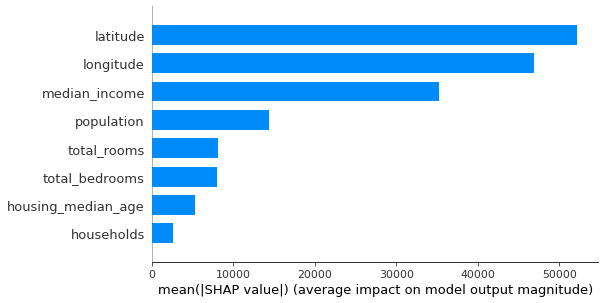

In [136]:
shap.summary_plot(xg_shap_values, X_shap, plot_type="bar", feature_names=test_pd.columns[:-1])

The second plot is made of all the dots in the testing data. It demonstrates the following information:
1. Feature importance: Variables are ranked in descending order.
2. Impact: The horizontal location shows whether the effect of that value is associated with a higher or lower prediction.
3. Original value: Color shows whether that variable is high (in red) or low (in blue) for that observation.
4. Correlation: A high level of the “median_income” content has a high and positive impact on the price estimation. The “high” comes from the red color, and the “positive” impact is shown on the X-axis. Similarly, we will say the “latitude” is negatively correlated with the target variable.

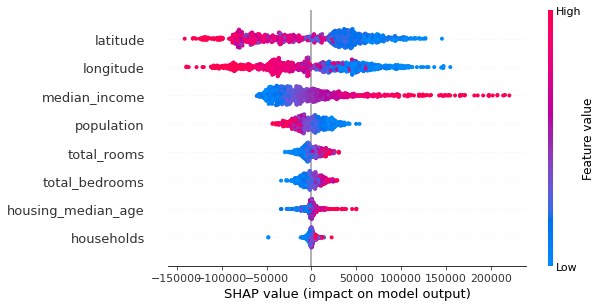

In [137]:
shap.summary_plot(xg_shap_values, X_shap, feature_names=test_pd.columns[:-1])

The final plot shows a simplified summary plot with colours indicating correlation to target variable

  It highlights the correlations in colors. The red color means a feature is positively correlated with the target variable
  Source: https://towardsdatascience.com/explain-your-model-with-the-shap-values-bc36aac4de3d

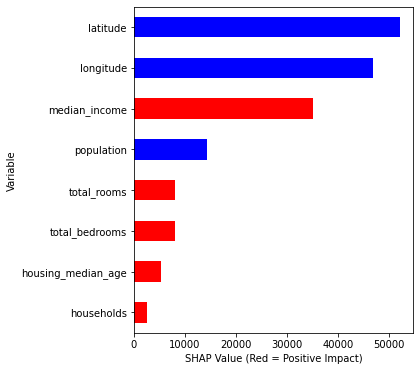

In [138]:
ABS_SHAP(xg_shap_values, pd.DataFrame(X_shap, columns=test_pd.columns[:-1])) 

## Light Gradient Boost Regressor

### Random search optimiser

In [0]:
# random_grid = {
#     'learning_rate': [0.05,0.1],
#     'num_leaves': [10,20,30,40,90,200],
#     'boosting_type' : ['gbdt'],
#     'objective' : ['binary'],
#     'max_depth' : [5,6,7,8,-1],
#     'random_state' : [501,None], 
#     'colsample_bytree' : [0.5,0.7,1.0],
#     'subsample' : [0.5,0.7,1.0],
#     'min_split_gain' : [0.0,0.01],
#     'min_data_in_leaf':[10],
#     'metric':['auc']
#     }

In [0]:
# from lightgbm import LGBMRegressor

# # Use the random grid to search for best hyperparameters
# # First create the base model to tune
# lg = LGBMRegressor()
# # Random search of parameters, using 3 fold cross validation, 
# # search across 100 different combinations, and use all available cores
# random_lg = RandomizedSearchCV(estimator = lg, param_distributions = random_grid, n_iter = 1000, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# # Fit the random search model
# random_lg.fit(X_train, y_train)

In [0]:
# random_lg.best_estimator_

In [0]:
# evaluate_model(random_lg, X_train, y_train, X_test, y_test)

### Train an optimised LGBoost model

In [143]:
from lightgbm import LGBMRegressor
model_lg = LGBMRegressor()
%time model_lg.fit(X_train, y_train)

CPU times: user 305 ms, sys: 10 ms, total: 315 ms
Wall time: 320 ms


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [144]:
evaluate_model(model_lg, X_train, y_train, X_test, y_test)

Model Score for Training data: 0.8750530663252905
Model Score for Testing data: 0.8163254105424507
Root Mean Squared Error is 48471.93320137177


### Standard feature importance plots
Here we use the standard feature importance plots common to sklearn and xgboost libraries.

The key takeaway is that these built in plots can show conflicting, disparate or ambiguous results.

In [0]:
import lightgbm

[Text(0, 0, 'longitude'),
 Text(0, 0, 'latitude'),
 Text(0, 0, 'housing_median_age'),
 Text(0, 0, 'total_rooms'),
 Text(0, 0, 'total_bedrooms'),
 Text(0, 0, 'population'),
 Text(0, 0, 'households'),
 Text(0, 0, 'median_income')]

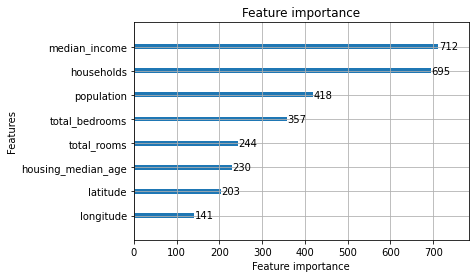

In [146]:
lightgbm.plot_importance(model_lg).set_yticklabels(test_pd.columns[:-1])

[Text(0, 0, 'longitude'),
 Text(0, 0, 'latitude'),
 Text(0, 0, 'housing_median_age'),
 Text(0, 0, 'total_rooms'),
 Text(0, 0, 'total_bedrooms'),
 Text(0, 0, 'population'),
 Text(0, 0, 'households'),
 Text(0, 0, 'median_income')]

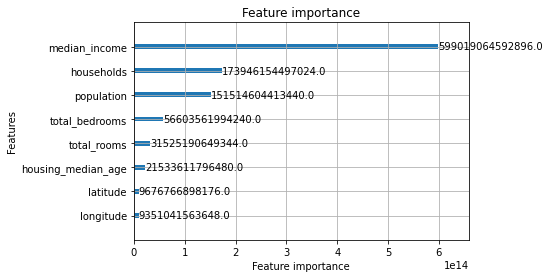

In [147]:
lightgbm.plot_importance(model_lg, importance_type="gain").set_yticklabels(test_pd.columns[:-1])

### Use Shap library to explain feature contribution
BUG: The aditivity check fails in the TreeExplainer on LGBoost 
https://github.com/slundberg/shap/issues/1071

Adjust the bg_size downwards to fix this
* 600 seems to be the limit as of 10 May 2020

In [156]:
# Calculate shapley values for the model
%time lg_shap_values, X_shap = calc_shap_values(model_lg, bg_size=180, X_source=X_test)

CPU times: user 1.52 s, sys: 7.02 ms, total: 1.52 s
Wall time: 1.54 s


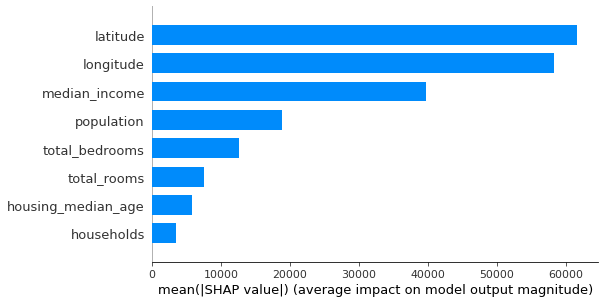

In [157]:
shap.summary_plot(lg_shap_values, X_test, plot_type="bar", feature_names=test_pd.columns[:-1])

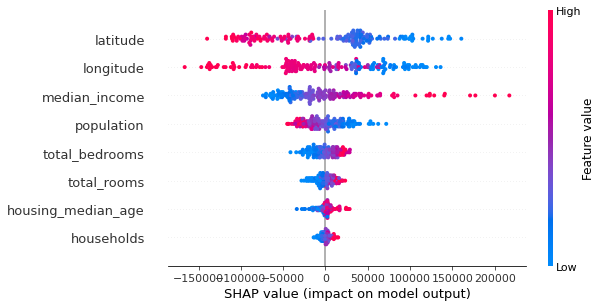

In [158]:
shap.summary_plot(lg_shap_values, X_shap, feature_names=test_pd.columns[:-1])

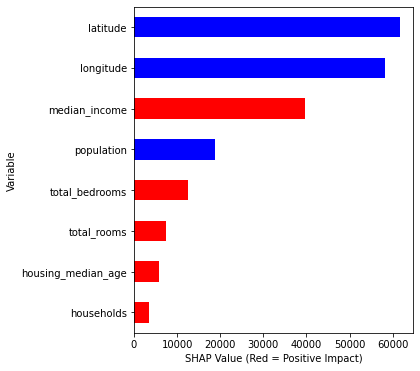

In [159]:
ABS_SHAP(lg_shap_values, pd.DataFrame(X_shap, columns=test_pd.columns[:-1])) 

## Random Forest Regression

### Random search optimiser

In [0]:
# from sklearn.model_selection import RandomizedSearchCV
# # Number of trees in random forest
# n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# # Number of features to consider at every split
# max_features = ['auto', 'sqrt']
# # Maximum number of levels in tree
# max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
# max_depth.append(None)
# # Minimum number of samples required to split a node
# min_samples_split = [2, 5, 10]
# # Minimum number of samples required at each leaf node
# min_samples_leaf = [1, 2, 4]
# # Method of selecting samples for training each tree
# bootstrap = [True, False]
# # Create the random grid
# random_grid = {'n_estimators': n_estimators,
#                'max_features': max_features,
#                'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf,
#                'bootstrap': bootstrap}
# print(random_grid)

In [0]:
# from sklearn.ensemble import RandomForestRegressor
# # Use the random grid to search for best hyperparameters
# # First create the base model to tune
# rf = RandomForestRegressor(n_jobs=-1)
# # Random search of parameters, using 3 fold cross validation, 
# # search across 100 different combinations, and use all available cores
# random_rf = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# # Fit the random search model
# random_rf.fit(X_train, y_train)

In [0]:
# random_rf.best_estimator_

In [0]:
# evaluate_model(random_rf, X_train, y_train, X_test, y_test)

### Train optimised Random Forest model

In [164]:
from sklearn.ensemble import RandomForestRegressor
model_rf = RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=80, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=2,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1800, n_jobs=-1, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)
%time model_rf.fit(X_train,y_train)

CPU times: user 4min 12s, sys: 791 ms, total: 4min 13s
Wall time: 2min 10s


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=80, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=2,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1800, n_jobs=-1, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [165]:
evaluate_model(model_rf, X_train, y_train, X_test, y_test)

Model Score for Training data: 0.9605582689976389
Model Score for Testing data: 0.8108134243496904
Root Mean Squared Error is 49193.86673256686


### Standard feature importance plots
Here we use the standard feature importance plots common to sklearn and xgboost libraries.

The key takeaway is that these built in plots can show conflicting, disparate or ambiguous results.

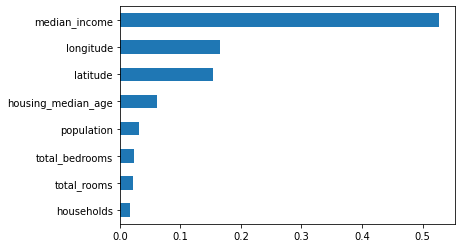

In [166]:
feat_importances = pd.Series(model_rf.feature_importances_, index=test_pd.columns[:-1])
feat_importances.nlargest(len(test_pd.columns[:-1]))[::-1].plot(kind='barh')

### Use Shap library to explain feature contribution

In [167]:
# Calculate shapley values for the model
%time rf_shap_values, X_shap = calc_shap_values(model_rf, bg_size=100, X_source=X_test)

 99%|===================| 99/100 [01:35<00:00]       

CPU times: user 1min 36s, sys: 982 ms, total: 1min 37s
Wall time: 1min 37s


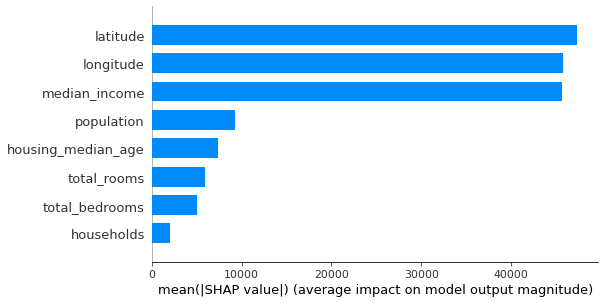

In [168]:
shap.summary_plot(rf_shap_values, X_test, plot_type="bar", feature_names=test_pd.columns[:-1])

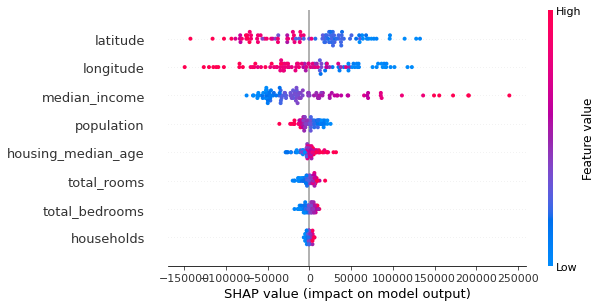

In [169]:
shap.summary_plot(rf_shap_values, X_shap, feature_names=test_pd.columns[:-1])

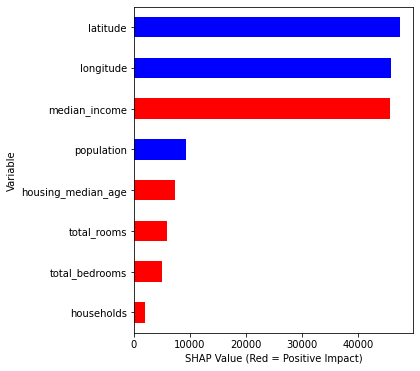

In [170]:
ABS_SHAP(rf_shap_values, pd.DataFrame(X_shap, columns=test_pd.columns[:-1])) 

# Unused Regression Models

## Train a Bayesian Ridge Regressor

In [171]:
from sklearn.linear_model import BayesianRidge
model_br = BayesianRidge()
%time model_br.fit(X_train,y_train)

CPU times: user 16.2 ms, sys: 14 ms, total: 30.2 ms
Wall time: 24.7 ms


BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, alpha_init=None,
              compute_score=False, copy_X=True, fit_intercept=True,
              lambda_1=1e-06, lambda_2=1e-06, lambda_init=None, n_iter=300,
              normalize=False, tol=0.001, verbose=False)

In [172]:
evaluate_model(model_br, X_train, y_train, X_test, y_test)

Model Score for Training data: 0.6413373752225843
Model Score for Testing data: 0.6195245662847987
Root Mean Squared Error is 69763.63680959698


## Train a Decision Tree Regressor

In [173]:
from sklearn.tree import DecisionTreeRegressor
model_dt = DecisionTreeRegressor()
%time model_dt.fit(X_train,y_train)

CPU times: user 217 ms, sys: 77 ms, total: 294 ms
Wall time: 210 ms


DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [174]:
evaluate_model(model_dt, X_train, y_train, X_test, y_test)

Model Score for Training data: 1.0
Model Score for Testing data: 0.6490075367587544
Root Mean Squared Error is 67006.15500216131


## Train a Linear Regressor

In [175]:
from sklearn.linear_model import LinearRegression
model_lr = LinearRegression()
%time model_lr.fit(X_train,y_train)

CPU times: user 4.44 ms, sys: 5 ms, total: 9.44 ms
Wall time: 9.45 ms


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [176]:
evaluate_model(model_rf, X_train, y_train, X_test, y_test)

Model Score for Training data: 0.9605582689976389
Model Score for Testing data: 0.8108134243496904
Root Mean Squared Error is 49193.86673256686


## Train a Support Vector Regressor
This techniques finds the optimal hyperplane to seperate observations into classes

In [0]:
from sklearn.svm import SVR

In [178]:
# Support Vector Regression
model_svr = SVR(kernel="rbf", cache_size=32000)
%time model_svr.fit(X_train,y_train)

CPU times: user 19.2 s, sys: 172 ms, total: 19.4 s
Wall time: 19.4 s


SVR(C=1.0, cache_size=32000, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [179]:
evaluate_model(model_rf, X_train, y_train, X_test, y_test)

Model Score for Training data: 0.9605582689976389
Model Score for Testing data: 0.8108134243496904
Root Mean Squared Error is 49193.86673256686
